In [4]:
import pandas as pd
import logging
from datetime import datetime
import argparse
import os
import math
import sys, inspect

from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast

import numpy as np
from scipy.stats import wasserstein_distance

import torch
from torch.utils.data.dataloader import DataLoader


import matplotlib.pyplot as plt
from scipy import stats

# add parent directory to syspath
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

from utils import *
from dataset import WhQuestionsDataset
from models import DistilBertForWhQuestionInference, BertForWhQuestionInference
from trainer import Trainer

In [45]:
path_to_datasets = 'datasets/wh-questions-question-context'
input_dataset = 'test'
use_context = False
eval_path = os.path.join(path_to_datasets, input_dataset + '_db.csv')
params_path = 'bert_standard_params'
model = BertForWhQuestionInference()
model.load_state_dict(torch.load(params_path, map_location=torch.device('cpu')))
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
batch_size = 32

In [46]:
if use_context:
    eval_sentences, eval_labels = read_dataset_split_with_context(eval_path)
else:
    eval_sentences, eval_labels = read_dataset_split_sentence_only(eval_path)

eval_encodings = tokenizer(eval_sentences, truncation=True, padding=True)
eval_dataset = WhQuestionsDataset(eval_encodings, eval_labels)

# check if we're on a gpu
if torch.cuda.is_available():
	device = torch.cuda.current_device()
	model = torch.nn.DataParallel(model).to(device)
else:
	device = torch.device("cpu")

#model.eval()
loader = DataLoader(eval_dataset, batch_size=batch_size)

encodings = []
outputs = []
all_labels = []
distances = []

for it, data in enumerate(loader):
	# place data on the correct device
	input_ids = data['input_ids'].to(device)
	encodings.extend(input_ids)

	attention_mask = data['attention_mask'].to(device)
	labels = data['labels'].to(device)
	all_labels.extend(labels)

	with torch.no_grad():
		output = model(input_ids, attention_mask)
		outputs.extend(output)
		
mkdir_p('outputs_for_analysis')

rows = []
sentences = []
for i in range(len(all_labels)):
	distances.append(wasserstein_distance(outputs[i].cpu(), all_labels[i].cpu()))
	tokens = tokenizer.convert_ids_to_tokens(encodings[i])
	sentence = tokenizer.convert_tokens_to_string(tokens)
	sentence = sentence.replace('[CLS]', '')
	sentence = sentence.replace('[PAD]', '')
	sentence = sentence.replace('[SEP]', '')
	sentences.append(sentence)
	rounded_output = str([round(i, 4) for i in outputs[i].tolist()])
	rounded_label = str([round(i, 4) for i in all_labels[i].tolist()])
	row = sentence + '\t' + rounded_output + '\t' + rounded_label + '\t' + str(distances[i]) + '\n'
	rows.append(row)
	if i % 20 == 0:
		print('sentence:\n', sentence)
		print('prediction:\n', outputs[i])
		print('gold:\n', all_labels[i])
		print('distance:\n', distances[i])
		print('------')

print('Wasserstein distance:', np.mean(distances))

write_path = os.path.join('outputs_for_analysis', params_path + '_' + input_dataset + '_db.csv')
f = open(write_path, 'w')
head_line = "Sentence\tOutput\tLabel\tDistance\n"
f.write(head_line)
for row in rows:
    f.write(row)
f.close()

sentence:
  who do you think                                                
prediction:
 tensor([0.1365, 0.2351, 0.3591, 0.2694])
gold:
 tensor([0.1037, 0.0458, 0.5111, 0.3395])
distance:
 0.11104289814829826
------
sentence:
  what's your favorite news                                              
prediction:
 tensor([0.1106, 0.1093, 0.7019, 0.0783])
gold:
 tensor([1.5167e-01, 5.8333e-02, 7.9000e-01, 1.2336e-17])
distance:
 0.06460748333483934
------
sentence:
  and, yet, what am i going to do when i have a couple double a batteries to toss out                               
prediction:
 tensor([0.2476, 0.2910, 0.2204, 0.2409])
gold:
 tensor([0.0953, 0.2721, 0.4979, 0.1347])
distance:
 0.11568747647106647
------
sentence:
  and, uh, what's the one comes on after that                                       
prediction:
 tensor([0.1414, 0.1708, 0.6033, 0.0845])
gold:
 tensor([0.0562, 0.0819, 0.8600, 0.0019])
distance:
 0.12834709545131773
------
sentence:
  uh, what do you think about, 

In [312]:
worst_indices = np.argpartition(distances,-20)[-20:]
for i in worst_indices:
    print('sentence:\n', sentences[i])
    print('prediction:\n', outputs[i])
    print('gold:\n', all_labels[i])
    print('distance:\n', distances[i])
    print('------')

sentence:
  uh, when was the last time you saw a truck that didn't belch, smoke, or, uh,                            
prediction:
 tensor([0.1082, 0.1037, 0.6641, 0.1240])
gold:
 tensor([0.1195, 0.3026, 0.3568, 0.2205])
distance:
 0.1534813493490219
------
sentence:
  why don't you tell me about yours                                           
prediction:
 tensor([0.2148, 0.2579, 0.3055, 0.2218])
gold:
 tensor([0.0900, 0.1958, 0.1000, 0.6137])
distance:
 0.15421613864600658
------
sentence:
  what do we have left                                               
prediction:
 tensor([0.3503, 0.2783, 0.2462, 0.1253])
gold:
 tensor([0.6585, 0.0415, 0.1390, 0.1605])
distance:
 0.15422709751874208
------
sentence:
  well, what did you find was most helpful in planning the birthday get together?                                    
prediction:
 tensor([0.3496, 0.3156, 0.2513, 0.0836])
gold:
 tensor([0.1914, 0.0967, 0.6738, 0.0381])
distance:
 0.1620910568162799
------
sentence:
  so, uh, what thi

In [311]:
worst_indices = np.argpartition(distances,20)[:20]
for i in worst_indices:
    print('sentence:\n', sentences[i])
    print('prediction:\n', outputs[i])
    print('gold:\n', all_labels[i])
    print('distance:\n', distances[i])
    print('------')

sentence:
  what do you think                                                
prediction:
 tensor([0.2036, 0.2495, 0.2253, 0.3216])
gold:
 tensor([0.2267, 0.2194, 0.3317, 0.2222])
distance:
 0.012955151498317719
------
sentence:
  what club do you follow                                               
prediction:
 tensor([0.1023, 0.1295, 0.7113, 0.0569])
gold:
 tensor([0.0732, 0.1363, 0.6853, 0.1053])
distance:
 0.01303773745894432
------
sentence:
  well, how'd you learn to do that to fix them up                                      
prediction:
 tensor([0.1163, 0.1655, 0.6512, 0.0670])
gold:
 tensor([0.0786, 0.1024, 0.6595, 0.1595])
distance:
 0.009962627664208412
------
sentence:
  so what's it been like up there?                                          
prediction:
 tensor([0.2655, 0.1866, 0.3523, 0.1956])
gold:
 tensor([0.2485, 0.1865, 0.2145, 0.3505])
distance:
 0.009443923830986023
------
sentence:
  when, when would people do it                                             
pred

(array([ 5.,  5.,  6.,  5.,  5.,  9., 15., 16., 10., 10., 16., 10., 15.,
        11., 13., 13., 11., 11.,  9.,  8.,  4.,  7.,  5.,  8.,  6.,  8.,
         4.,  3.,  2.,  1.,  4.,  4.,  7.,  6.,  1.,  5.,  4.,  2.,  2.,
         4.,  0.,  2.,  0.,  1.,  0.,  1.,  2.,  2.,  0.,  1.]),
 array([0.00625636, 0.01026305, 0.01426974, 0.01827643, 0.02228313,
        0.02628982, 0.03029651, 0.0343032 , 0.03830989, 0.04231658,
        0.04632327, 0.05032997, 0.05433666, 0.05834335, 0.06235004,
        0.06635673, 0.07036342, 0.07437011, 0.0783768 , 0.0823835 ,
        0.08639019, 0.09039688, 0.09440357, 0.09841026, 0.10241695,
        0.10642364, 0.11043034, 0.11443703, 0.11844372, 0.12245041,
        0.1264571 , 0.13046379, 0.13447048, 0.13847718, 0.14248387,
        0.14649056, 0.15049725, 0.15450394, 0.15851063, 0.16251732,
        0.16652402, 0.17053071, 0.1745374 , 0.17854409, 0.18255078,
        0.18655747, 0.19056416, 0.19457085, 0.19857755, 0.20258424,
        0.20659093]),
 <BarContainer

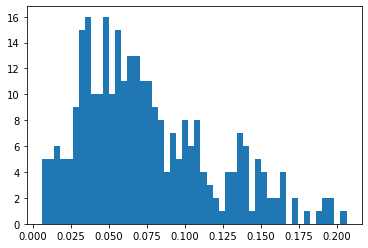

In [130]:
plt.hist(distances, bins=50)

In [50]:
mu, sigma = np.mean(distances), np.std(distances)
stats.norm.interval(0.95, loc=mu, scale=sigma)

(-0.009762289594458157, 0.159921027496501)

In [51]:
np.median(distances)

0.06563529744744301

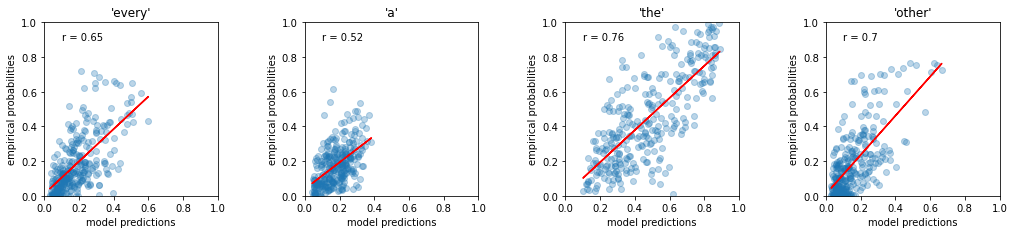

In [276]:
plots = ['every', 'a', 'the', 'other']
fig, axes = plt.subplots(1, 4, figsize=(14,3))
fig.tight_layout()

for i, ax in enumerate(axes.flatten()):
    predictions = [row[i] for row in outputs]
    labels = [row[i] for row in all_labels]
    ax.scatter(predictions, labels, alpha=0.3)
    m, b = np.polyfit(predictions, labels, 1)
    ax.plot(predictions, np.array(predictions) * m + b, color='r')
    r = round(np.corrcoef(predictions, labels)[0, 1], 2)
    ax.set_title('\''+ plots[i] + '\'')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('model predictions')
    ax.set_ylabel('empirical probabilities')
    ax.text(x=0.1, y=0.9, s='r = ' + str(r))

#print(np.corrcoef(every_predictions, every_labels))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [104]:
for i in range(4):
    predictions = [row[i] for row in outputs]
    labels = [row[i] for row in all_labels]
    print(np.corrcoef(predictions, labels)[0, 1])

0.6512021890139192
0.5231846425531395
0.761692697831715
0.6993643887313387


In [136]:
# http://www.jtrive.com/the-empirical-bootstrap-for-confidence-intervals-in-python.html
def bootstrap(data, n=1000, func=np.mean):
    """
    Generate `n` bootstrap samples, evaluating `func`
    at each resampling. `bootstrap` returns a function,
    which can be called to obtain confidence intervals
    of interest.
    """
    simulations = list()
    sample_size = len(data)
    xbar_init = np.mean(data)
    for c in range(n):
        itersample = np.random.choice(data, size=sample_size, replace=True)
        simulations.append(func(itersample))
    simulations.sort()
    def ci(p):
        """
        Return 2-sided symmetric confidence interval specified
        by p.
        """
        u_pval = (1+p)/2.
        l_pval = (1-u_pval)
        l_indx = int(np.floor(n*l_pval))
        u_indx = int(np.floor(n*u_pval))
        return(simulations[l_indx],simulations[u_indx])
    return(ci)

In [138]:
boot = bootstrap(distances, n=10000)
ci = boot(0.95)
print(ci)

(0.07026405052857569, 0.07998847023318802)


In [158]:
indices = np.argsort(distances)
magnitude_of_other_predictions = []
for i in indices[-20:]:
    print(sentences[i])
    print(distances[i])
    print('-----')
    magnitude_of_other_predictions.append(outputs[i][3])

avg_other_prediction = np.mean([row[3] for row in outputs])
print(avg_other_prediction)
print(np.mean(magnitude_of_other_predictions))

 uh, when was the last time you saw a truck that didn't belch, smoke, or, uh,                            
0.1534813493490219
-----
 why don't you tell me about yours                                           
0.15421613864600658
-----
 what do we have left                                               
0.15422709751874208
-----
 so how do you know this much about, um, stealing cars                                       
0.15569882653653622
-----
 so what do you know about it.                                            
0.1561877029016614
-----
 how do you usually find a, a new restaurant                                          
0.1611319544026628
-----
 well, what did you find was most helpful in planning the birthday get together?                                    
0.1620910568162799
-----
 and then, uh, who knows how they process it from there and what they turn it into                                 
0.1630471982061863
-----
 what do they,                                         

In [170]:
high_the_indices = []
for i in range(len(outputs)):
    if outputs[i][2] > 0.8:
        high_the_indices.append(i)

high_the_distances = []
for i in high_the_indices:
    print(sentences[i])
    print(outputs[i])
    print(distances[i])
    high_the_distances.append(distances[i])
    print('-----')
    
print(np.mean(high_the_distances))

 where'd you live at                                              
tensor([0.0404, 0.0542, 0.8604, 0.0450])
0.0062563600949943066
-----
 what, uh, school are you going to                                           
tensor([0.0543, 0.0511, 0.8429, 0.0517])
0.036407828563824296
-----
 what, uh, department do you work in                                           
tensor([0.0671, 0.0518, 0.8232, 0.0578])
0.03613716829568148
-----
 where do you live now                                               
tensor([0.0466, 0.0418, 0.8686, 0.0430])
0.04165673442184925
-----
 so where do you live at                                              
tensor([0.0699, 0.0609, 0.8255, 0.0438])
0.02187892887741327
-----
 what's the last movie you saw                                            
tensor([0.0728, 0.0742, 0.8025, 0.0505])
0.03329112660139799
-----
 what area do you live in                                              
tensor([0.0430, 0.0642, 0.8591, 0.0338])
0.04457903513684869
-----
 so what were y

In [181]:
print(sentences[0])
print(eval_sentences[0])
print(eval_path)

 who do you think                                                
who do you think 
datasets/wh-questions-question-context/test_db.csv


what
A
Every
The
how
A
Every
The
where
A


/Users/dharakyu/anaconda3/envs/cs224nproject/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dharakyu/anaconda3/envs/cs224nproject/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Every


/Users/dharakyu/anaconda3/envs/cs224nproject/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dharakyu/anaconda3/envs/cs224nproject/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


The


/Users/dharakyu/anaconda3/envs/cs224nproject/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dharakyu/anaconda3/envs/cs224nproject/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


why
A
Every
The
who
A
Every
The
when
A
Every
The


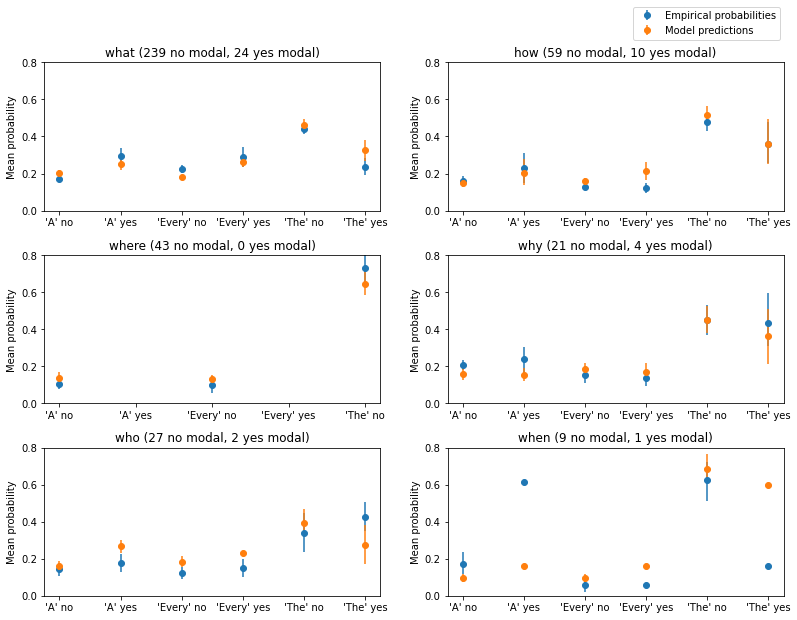

In [310]:
# TODO: look at whether differences across modals/wh words align with empirical data
valid_df = pd.read_csv('datasets/wh-questions-question-context/valid_db.csv', sep='\t')
original_test_df = pd.read_csv('datasets/wh-questions-question-context/test_db.csv', sep='\t')
test_df = pd.concat([valid_df, original_test_df])

modals = ['what', 'how', 'where', 'why', 'who', 'when']
categories = ['A', 'Every', 'The']
categories_for_plot = ['\'A\' no', '\'A\' yes', '\'Every\' no',
                       '\'Every\' yes', '\'The\' no', '\'The\' yes']

fig, axes = plt.subplots(3, 2, figsize=(11,8))
fig.tight_layout()

modal_present_list = list(test_df['ModalPresent'])
wh_word_list = list(test_df['Wh'])

for fignum, ax in enumerate(axes.flatten()):
    print(modals[fignum])
    curr_df = test_df[test_df['Wh'] == modals[fignum]]
    true_values = []
    pred_values = []
    
    true_cintervals = []
    pred_cintervals = []
    
    for i, category in enumerate(categories):
        print(category)
        modal_present_label_items = list(curr_df[curr_df['ModalPresent'] == 1][category])
        modal_not_present_label_items = list(curr_df[curr_df['ModalPresent'] == 0][category])
        
        modal_present_indices = curr_df.index[curr_df['ModalPresent'] == 1].tolist()
        modal_present_pred_items = [outputs[index][i] for index in modal_present_indices]
        
        modal_not_present_indices = curr_df.index[curr_df['ModalPresent'] == 0].tolist()
        modal_not_present_pred_items = [outputs[index][i] for index in modal_not_present_indices]
        
        true_values.append(np.mean(modal_not_present_label_items))
        true_values.append(np.mean(modal_present_label_items))
        
        pred_values.append(np.mean(modal_not_present_pred_items))
        pred_values.append(np.mean(modal_present_pred_items))
        
        boot1 = bootstrap(modal_not_present_label_items, n=1000)
        ci1 = boot1(0.95)
        boot2 = bootstrap(modal_present_label_items, n=1000)
        ci2 = boot2(0.95)
        
        boot3 = bootstrap(modal_not_present_pred_items, n=1000)
        ci3 = boot3(0.95)
        boot4 = bootstrap(modal_present_pred_items, n=1000)
        ci4 = boot4(0.95)
        
        true_cintervals.append(ci1)
        true_cintervals.append(ci2)
        
        pred_cintervals.append(ci3)
        pred_cintervals.append(ci4)
        
    #ax.scatter(categories_for_plot, true_values)
    #ax.scatter(categories_for_plot, pred_values)
    ax.set_title(modals[fignum] + " (" + str(len(modal_not_present_indices)) + ' no modal, ' +
                str(len(modal_present_indices)) + ' yes modal)')
    ax.set_ylim([0, 0.8])
    ax.set_ylabel('Mean probability')
    
    #true_error_delta = np.abs(np.array([true_values, true_values]) - np.array(true_cintervals).T)
    #print(true_values)
    #print(np.array([true_values, true_values]))
    #print(np.array(true_cintervals).T)
    pred_values = np.array(pred_values)
    if modals[fignum] == 'where':
        pred_values[1] = np.nan
        pred_values[3] = np.nan
        pred_values[5] = np.nan
        
    true_error_delta = np.abs(np.array([true_values, true_values]) - np.array(true_cintervals).T)
    pred_error_delta = np.abs(np.array([pred_values, pred_values]) - np.array(pred_cintervals).T)
    if modals[fignum] == 'when':
        pred_error_delta[:, 1] = np.nan
        pred_error_delta[:, 3] = np.nan
        pred_error_delta[:, 5] = np.nan
        
    ax.errorbar(categories_for_plot, true_values, fmt='o', yerr=true_error_delta, 
                label='Empirical probabilities')
    ax.errorbar(categories_for_plot, pred_values, fmt='o', yerr=pred_error_delta, 
                label='Model predictions')

handles, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.78, 1.08))
plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()